# Benchmark: Granule enrichment vs. extrasomatic baseline

This notebook benchmarks whether detected RNA granules are enriched beyond the ambient extrasomatic baseline. Both metrics use **composition-based logFC** for comparability:
1. **Baseline logFC**: log2(frac_extra/frac_soma) — how much more concentrated in extrasomatic vs somatic compartments.
2. **Granule enrichment logFC**: log2(frac_in_granules/frac_in_non_granule_extra) — among extrasomatic transcripts only, how much more concentrated in granules vs non-granule extrasomatic.
3. **Scatter plot**: x-axis = baseline logFC, y-axis = granule enrichment. Granule markers above the diagonal indicate granules exceed the ambient extrasomatic baseline. Genes from `genes.csv`.
4. **Excess Δ** and **regression reference**: Δ = granule_enrichment − baseline_logFC. A regression of granule_enrichment ~ baseline_logFC is fit on *non-marker* genes; markers above this line have enrichment beyond what baseline predicts (supporting bona fide structure).
5. **Statistical tests**: One-sample Wilcoxon (markers Δ > 0), Mann-Whitney (markers vs non-markers Δ), and box plot of Δ.

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.spatial import cKDTree
from scipy.stats import wilcoxon

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0

In [3]:
# File paths (use outcome/ for granules; use output/ if granules are in output/)
import os
dataset = "MERSCOPE_WT_1"
data_path = f"../data/{dataset}/"
outcome_path = f"../output/{dataset}/"

# Input files
transcripts_path = data_path + "processed_data/transcripts.parquet"
granules_path = outcome_path + "all_granules.parquet"
spots_path = data_path + "processed_data/spots.h5ad"

## 1. Load data and filter granules

In [4]:
# Load transcripts (overlaps_nucleus = 1 means in soma)
transcripts = pd.read_parquet(transcripts_path)
print(f"Transcripts: {len(transcripts)}")
print(f"Transcript columns: {list(transcripts.columns)}")

# Load spots
spots = sc.read_h5ad(spots_path)
print(f"Spots: {spots.n_obs}")
print(f"Spot obs columns: {list(spots.obs.columns)}")

# Load granules
granules = pd.read_parquet(granules_path)
print(f"All granules (raw): {len(granules)}")

Transcripts: 103398068
Transcript columns: ['cell_id', 'overlaps_nucleus', 'target', 'global_x', 'global_y', 'global_z']
Spots: 17667
Spot obs columns: ['spot_id', 'global_x', 'global_y', 'global_y_new', 'global_x_new', 'region_labels', 'brain_area']
All granules (raw): 1154416


In [5]:
# Filter granules: keep those with sphere_r <= 4, in_soma_ratio <= 0.1, nc_ratio <= 0.1
# (filter OUT granules with sphere_r > 4, in_soma_ratio > 0.1, nc_ratio > 0.1)
granules = granules[granules["sphere_r"] <= 4].copy().reset_index(drop=True)

# Load nc_genes for negative control filtering (same as benchmark_filtering.ipynb)
nc_genes_df = pd.read_csv(data_path + "processed_data/negative_controls.csv")
nc_genes = list(nc_genes_df["Gene"])

def make_tree_3d(d1, d2, d3):
    points = np.c_[np.ravel(d1), np.ravel(d2), np.ravel(d3)]
    return cKDTree(points)

def compute_nc_ratio(granules_df, transcripts_df, nc_genes_list):
    nc_transcripts = transcripts_df[transcripts_df["target"].isin(nc_genes_list)]
    if nc_transcripts.shape[0] == 0:
        return np.zeros(len(granules_df))
    z_col = "sphere_z" if "sphere_z" in granules_df.columns else "layer_z"
    tree = make_tree_3d(
        np.array(nc_transcripts["global_x"]),
        np.array(nc_transcripts["global_y"]),
        np.array(nc_transcripts["global_z"]),
    )
    centers = granules_df[["sphere_x", "sphere_y", z_col]].to_numpy()
    radii = granules_df["sphere_r"].to_numpy()
    sizes = granules_df["size"].to_numpy().astype(float)
    counts = np.array([len(tree.query_ball_point(c, r)) for c, r in zip(centers, radii)])
    nc_ratio = np.where(sizes > 0, counts / sizes, 0.0)
    return nc_ratio

nc_ratio = compute_nc_ratio(granules, transcripts, nc_genes)
granules = granules.copy()
granules["nc_ratio"] = nc_ratio

# Apply filters
granules = granules[granules["in_soma_ratio"] <= 0.1].copy()
granules = granules[(granules["nc_ratio"] == 0) | (granules["nc_ratio"] < 0.1)].copy().reset_index(drop=True)

print(f"True RNA granules (after all filters): {len(granules)}")

True RNA granules (after all filters): 680616


## 2. Map transcripts to spots and build soma/extrasomatic pseudo counts

In [6]:
# Map transcripts to spots: transcript is in spot only if it falls inside the 50x50 square
# Spot square: [sx-25, sx+25) x [sy-25, sy+25) where (sx, sy) is spot centroid
GRID_LEN = 50
HALF_LEN = GRID_LEN / 2

spot_x = spots.obs["global_x"].values
spot_y = spots.obs["global_y"].values
tx_x = transcripts["global_x"].values
tx_y = transcripts["global_y"].values

spot_idx = np.full(len(transcripts), -1, dtype=np.int64)
for i in range(len(spot_x)):
    in_spot = (
        (tx_x >= spot_x[i] - HALF_LEN) & (tx_x < spot_x[i] + HALF_LEN) &
        (tx_y >= spot_y[i] - HALF_LEN) & (tx_y < spot_y[i] + HALF_LEN)
    )
    spot_idx[in_spot] = i
    if i % 2000 == 0:
        print(f"Transcripts in spot squares: {i}")

transcripts["spot_idx"] = spot_idx
n_assigned = (spot_idx >= 0).sum()
print(f"Transcripts in spot squares: {n_assigned} / {len(transcripts)}")

Transcripts in spot squares: 0
Transcripts in spot squares: 2000
Transcripts in spot squares: 4000
Transcripts in spot squares: 6000
Transcripts in spot squares: 8000
Transcripts in spot squares: 10000
Transcripts in spot squares: 12000
Transcripts in spot squares: 14000
Transcripts in spot squares: 16000
Transcripts in spot squares: 103398068 / 103398068


In [7]:
# Load gene list (use genes.csv for all genes in analysis)
genes_df = pd.read_csv(data_path + "processed_data/genes.csv")
gene_col = genes_df.columns[0]  # typically "genes"
genes_all = list(genes_df[gene_col].dropna().unique())
print(f"Genes from genes.csv: {len(genes_all)}")

# Build per-spot, per-gene counts: in_soma and extrasomatic
# overlaps_nucleus: 1 = in soma, 0 = extrasomatic
in_soma_col = "overlaps_nucleus"
if in_soma_col not in transcripts.columns:
    raise KeyError(f"Transcripts must have '{in_soma_col}' column")

trans_in_spots = transcripts[transcripts["spot_idx"] >= 0].copy()
trans_in_spots["in_soma"] = (trans_in_spots[in_soma_col] == 1).astype(int)
trans_in_spots["extra"] = 1 - trans_in_spots["in_soma"]

# Aggregate: (spot_idx, gene) -> count_soma, count_extra
counts_soma = trans_in_spots.groupby(["spot_idx", "target"])["in_soma"].sum().unstack(fill_value=0)
counts_extra = trans_in_spots.groupby(["spot_idx", "target"])["extra"].sum().unstack(fill_value=0)

# Use genes from genes.csv; fill 0 for genes with no counts
counts_soma = counts_soma.reindex(columns=genes_all, fill_value=0)
counts_extra = counts_extra.reindex(columns=genes_all, fill_value=0)

print(f"Genes: {len(genes_all)}, Spots with counts: {counts_soma.shape[0]}")

Genes from genes.csv: 290
Genes: 290, Spots with counts: 12168


## 3. Baseline logFC (extrasomatic vs somatic)

Composition-based: log2(frac_extra/frac_soma). P-value from spot-level paired Wilcoxon.

In [8]:
# --- Baseline: composition-based logFC (extrasomatic vs somatic) ---
# Makes baseline comparable to granule enrichment (both are composition fold-changes).
# baseline_logFC = log2(frac_extra/frac_soma) = how much more concentrated in extra than soma
mask_soma = transcripts[in_soma_col] == 1
mask_extra = transcripts[in_soma_col] != 1
total_soma = mask_soma.sum()
total_extra = mask_extra.sum()

eps = 0.5
baseline_logFC = []
baseline_pval_paired = []  # keep spot-level p-value for significance
for g in genes_all:
    mask_g = transcripts["target"] == g
    count_soma_g = (mask_g & mask_soma).sum()
    count_extra_g = (mask_g & mask_extra).sum()
    frac_soma = (count_soma_g + eps) / (total_soma + eps)
    frac_extra = (count_extra_g + eps) / (total_extra + eps)
    logfc = np.log2(frac_extra) - np.log2(frac_soma)
    baseline_logFC.append(logfc)
    s = counts_soma[g].values + 1.0
    e = counts_extra[g].values + 1.0
    try:
        stat, p = wilcoxon(e, s, alternative="two-sided")
        baseline_pval_paired.append(p)
    except Exception:
        baseline_pval_paired.append(1.0)

baseline_df = pd.DataFrame({
    "gene": genes_all,
    "baseline_logFC": baseline_logFC,
    "baseline_pval": baseline_pval_paired,
})
print(baseline_df.head(10))

     gene  baseline_logFC  baseline_pval
0    Igf2       -1.304535   7.371994e-74
1  Pdgfra       -1.498258   1.317896e-47
2  S100a6       -0.184842   0.000000e+00
3  Col6a1       -2.613868  1.021367e-145
4  Col1a1       -1.730092   3.508555e-10
5   Grik5       -0.570461   0.000000e+00
6   Calb2       -0.720582  4.868937e-274
7    Eno2        0.025845   0.000000e+00
8   Stx1a       -0.306471   0.000000e+00
9   Pvalb        0.370921   0.000000e+00


## 4. Granule enrichment statistic

In [9]:
# Determine which transcripts fall inside any filtered granule
# Optimized: reverse the loop - iterate over granules (~680k) instead of transcripts (~100M).
# For each granule, query transcripts inside its sphere and mark them.
z_col = "layer_z"
tx_xyz = transcripts[["global_x", "global_y", "global_z"]].to_numpy(dtype=np.float64)
tree_tx = cKDTree(tx_xyz)

in_granule = np.zeros(len(transcripts), dtype=np.int8)
gnl_centers = granules[["sphere_x", "sphere_y", z_col]].to_numpy(dtype=np.float64)
gnl_radii = granules["sphere_r"].to_numpy(dtype=np.float64)

for i in range(len(granules)):
    idx = tree_tx.query_ball_point(gnl_centers[i], gnl_radii[i] + 0.1)
    if len(idx) > 0:
        in_granule[idx] = 1

transcripts["in_granule"] = in_granule
print(f"Transcripts in granules: {in_granule.sum()} / {len(transcripts)}")

Transcripts in granules: 6708721 / 103398068


In [10]:
# Granule enrichment: log2(frac_in_granules / frac_in_non_granule_extrasomatic) per gene
# EXTRASOMATIC ONLY: compare composition in granules vs non-granule extrasomatic (comparable to baseline)
mask_extra = transcripts[in_soma_col] != 1
mask_in_gnl_extra = (transcripts["in_granule"] == 1) & mask_extra
mask_non_gnl_extra = (transcripts["in_granule"] == 0) & mask_extra
total_tx_in_gnl_extra = mask_in_gnl_extra.sum()
total_tx_non_gnl_extra = mask_non_gnl_extra.sum()

granule_enrichment = []
eps = 0.5
for idx, g in enumerate(genes_all):
    mask_g = transcripts["target"] == g
    in_gnl_extra_g = (mask_in_gnl_extra & mask_g).sum()
    non_gnl_extra_g = (mask_non_gnl_extra & mask_g).sum()
    frac_gnl = (in_gnl_extra_g + eps) / (total_tx_in_gnl_extra + eps)
    frac_non = (non_gnl_extra_g + eps) / (total_tx_non_gnl_extra + eps)
    enr = np.log2(frac_gnl) - np.log2(frac_non)
    granule_enrichment.append(enr)
    if idx % 50 == 0:
        print(f"Granule enrichment: {idx} / {len(genes_all)}")

enrichment_df = pd.DataFrame({"gene": genes_all, "granule_enrichment": granule_enrichment})

Granule enrichment: 0 / 290
Granule enrichment: 50 / 290
Granule enrichment: 100 / 290
Granule enrichment: 150 / 290
Granule enrichment: 200 / 290
Granule enrichment: 250 / 290


In [11]:
# Merge baseline and enrichment; restrict to granule markers for scatter
granule_markers = ['Syn1', 'Cyfip2', 'Vamp2', 'Bsn', 'Stx1a', 'Map2', 'Nfasc', 'Slc17a7', 'Gria1', 'Map1a', 'Ddn', 'Gap43', 'Mapt', 'Gphn', 'Homer2', 'Slc17a6', 'Dlg3', 'Nlgn2', 'Gria2', 'Nlgn1', 'Nav1', 'Slc32a1', 'Tubb3', 'Dlg4', 'Syt1', 'Camk2a', 'Nrxn1', 'Syp', 'Nlgn3', 'Cplx2', 'Ank3', 'Shank1', 'Homer1', 'Shank3']

plot_df = baseline_df.merge(enrichment_df, on="gene", how="inner")
plot_df_markers = plot_df[plot_df["gene"].isin(granule_markers)].copy()

print(f"Genes in plot: {len(plot_df)}, Markers: {len(plot_df_markers)}")

Genes in plot: 290, Markers: 34


### Alternative approaches to shift granule markers up

Optional alternatives you can try:

1. **Granule enrichment vs soma**: Define granule enrichment as log2(frac_in_granules/frac_soma) so both axes use the same reference (soma). For markers, granules are typically more concentrated than bulk extrasomatic, so frac_in_granules/frac_soma > frac_extra/frac_soma → more markers above the diagonal.
2. **Minimum count filter**: Restrict to genes with ≥ N transcripts in granules (or in extrasomatic) so logFC is more stable; low-count noise can pull markers below the diagonal.
3. **Larger pseudocount**: Increase `eps` for low-count genes to shrink extreme logFCs and reduce sampling noise.

In [12]:
# Optional: alternative granule enrichment = "vs soma" (same reference as baseline)
# This often puts more markers above the diagonal: granules vs soma >= extrasomatic vs soma for true markers.
USE_ALT_GRANULE_VS_SOMA = False  # Set True to use this definition and replot
if USE_ALT_GRANULE_VS_SOMA:
    total_soma = (transcripts[in_soma_col] == 1).sum()
    total_in_gnl = (transcripts["in_granule"] == 1).sum()
    granule_enrichment_alt = []
    eps = 0.5
    for g in genes_all:
        mask_g = transcripts["target"] == g
        in_gnl_g = ((transcripts["in_granule"] == 1) & mask_g).sum()
        soma_g = ((transcripts[in_soma_col] == 1) & mask_g).sum()
        frac_soma = (soma_g + eps) / (total_soma + eps)
        frac_gnl = (in_gnl_g + eps) / (total_in_gnl + eps)
        granule_enrichment_alt.append(np.log2(frac_gnl) - np.log2(frac_soma))
    plot_df["granule_enrichment_alt"] = granule_enrichment_alt
    plot_df["granule_enrichment"] = plot_df["granule_enrichment_alt"]
    print("Using alternative granule enrichment (vs soma). Re-run the next cell (Excess Δ and regression) and below.")

## 6. Excess statistic (Δ) and regression reference line

**Δ = granule_enrichment − baseline_logFC**: "excess" enrichment in granules beyond the extrasomatic baseline. To ask whether markers have *more* granule enrichment than *expected* given their baseline, we fit a regression of granule_enrichment ~ baseline_logFC on **non-marker** genes and use that as the reference: markers above this line are enriched in granules beyond what baseline would predict (supporting bona fide structure).

In [13]:
# Excess statistic
plot_df["delta"] = plot_df["granule_enrichment"] - plot_df["baseline_logFC"]

# Regression on non-markers: granule_enrichment ~ baseline_logFC
non_marker = ~plot_df["gene"].isin(granule_markers)
X = plot_df.loc[non_marker, "baseline_logFC"].values.reshape(-1, 1)
y = plot_df.loc[non_marker, "granule_enrichment"].values
# Linear regression: y = slope * x + intercept
from numpy.linalg import lstsq
ones = np.ones((len(X), 1))
X_aug = np.hstack([X, ones])
coef, _, _, _ = lstsq(X_aug, y, rcond=None)
reg_slope, reg_intercept = coef[0], coef[1]
plot_df["expected_ge"] = reg_slope * plot_df["baseline_logFC"] + reg_intercept
plot_df["above_regression"] = plot_df["granule_enrichment"] > plot_df["expected_ge"]

# Re-derive plot_df_markers so it includes the new columns (delta, above_regression, expected_ge)
plot_df_markers = plot_df[plot_df["gene"].isin(granule_markers)].copy()

# Count markers above diagonal vs above regression line
above_diag = (plot_df_markers["granule_enrichment"] > plot_df_markers["baseline_logFC"]).sum()
above_reg = plot_df_markers["above_regression"].sum()
print(f"Regression (non-markers): granule_enrichment = {reg_slope:.4f} * baseline_logFC + {reg_intercept:.4f}")
print(f"Granule markers above diagonal (y=x): {above_diag} / {len(plot_df_markers)}")
print(f"Granule markers above regression line: {above_reg} / {len(plot_df_markers)}")
# Save plot_df with delta and regression columns for downstream use
plot_df.to_csv("../output/benchmark/benchmark_diffusion_df_new.csv", index=False)

Regression (non-markers): granule_enrichment = 0.2039 * baseline_logFC + -0.6875
Granule markers above diagonal (y=x): 20 / 34
Granule markers above regression line: 27 / 34


## 5. Scatter plot: baseline logFC vs granule enrichment

In [16]:
np.corrcoef(plot_df_markers["baseline_logFC"], plot_df_markers["granule_enrichment"])

array([[1.        , 0.25327709],
       [0.25327709, 1.        ]])

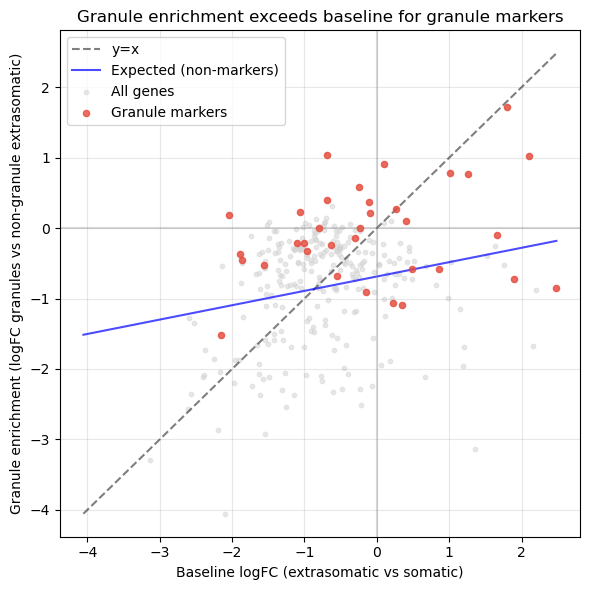

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Diagonal: granule_enrichment = baseline_logFC
lims = np.array([
    min(plot_df["baseline_logFC"].min(), plot_df["granule_enrichment"].min()),
    max(plot_df["baseline_logFC"].max(), plot_df["granule_enrichment"].max()),
])
ax.plot(lims, lims, "k--", alpha=0.5, label="y=x")
# Regression reference (fit on non-markers): expected granule enrichment given baseline
ax.plot(lims, reg_slope * lims + reg_intercept, "b-", alpha=0.7, lw=1.5, label="Expected (non-markers)")

# All genes (gray)
ax.scatter(plot_df["baseline_logFC"], plot_df["granule_enrichment"], c="lightgray", s=10, alpha=0.5, label="All genes")

# Granule markers (colored)
ax.scatter(plot_df_markers["baseline_logFC"], plot_df_markers["granule_enrichment"], c="#E74C3C", s=20, alpha=0.8, label="Granule markers", zorder=5)

# for _, row in plot_df_markers.iterrows():
#     ax.annotate(row["gene"], (row["baseline_logFC"], row["granule_enrichment"]),
#                 fontsize=8, alpha=0.9, xytext=(3, 3), textcoords="offset points")

ax.set_xlabel("Baseline logFC (extrasomatic vs somatic)")
ax.set_ylabel("Granule enrichment (logFC granules vs non-granule extrasomatic)")
ax.set_title("Granule enrichment exceeds baseline for granule markers")
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color="gray", linestyle="-", alpha=0.3)
ax.axvline(0, color="gray", linestyle="-", alpha=0.3)
plt.tight_layout()
# plt.savefig(outcome_path + "benchmark_diffusion_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Summary: fraction of granule markers above diagonal
above = (plot_df_markers["granule_enrichment"] > plot_df_markers["baseline_logFC"]).sum()
print(f"Granule markers above diagonal: {above} / {len(plot_df_markers)}")

## 7. Statistical tests and Δ distribution

Test whether granule markers have **positive excess** (Δ > 0) and whether their Δ distribution is higher than non-markers. This supports that granules are bona fide structures rather than driven by ambient RNA.

In [ ]:
from scipy.stats import wilcoxon, mannwhitneyu

# One-sample Wilcoxon: do marker Δ values have median > 0?
delta_markers = plot_df_markers["delta"].values
stat_1s, p_1s = wilcoxon(delta_markers, alternative="greater")
print(f"One-sample Wilcoxon (markers Δ > 0): stat={stat_1s:.4f}, p={p_1s:.4e}")
print(f"  Median Δ (markers): {np.median(delta_markers):.4f}")

# Mann-Whitney: marker Δ vs non-marker Δ
delta_non = plot_df.loc[non_marker, "delta"].values
stat_mw, p_mw = mannwhitneyu(delta_markers, delta_non, alternative="greater")
print(f"Mann-Whitney (markers Δ > non-markers Δ): stat={stat_mw:.4f}, p={p_mw:.4e}")
print(f"  Median Δ (non-markers): {np.median(delta_non):.4f}")

In [ ]:
# Box plot: Δ for markers vs non-markers
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_df["is_marker"] = plot_df["gene"].isin(granule_markers)
bp = ax.boxplot(
    [plot_df.loc[~plot_df["is_marker"], "delta"].values,
     plot_df.loc[plot_df["is_marker"], "delta"].values],
    labels=["Non-markers", "Granule markers"],
    patch_artist=True,
)
bp["boxes"][0].set_facecolor("lightgray")
bp["boxes"][1].set_facecolor("#E74C3C")
ax.axhline(0, color="gray", linestyle="--", alpha=0.5)
ax.set_ylabel("Δ (granule enrichment − baseline logFC)")
ax.set_title("Excess enrichment in granules")
plt.tight_layout()
plt.show()